In [1]:
import numpy as np

import os

from statsmodels.stats.api import DescrStatsW
from scipy.stats import ttest_rel, sem

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def labels_to_counts(labels, time_axis=0):
    onehot = np.zeros((labels.size, n_classes), dtype=int)
    onehot[np.arange(labels.size), labels] = 1
    
    return onehot.cumsum(axis=time_axis)


def log_utility(counts):
    return np.log(counts[:, 1:] + 1).sum(axis=1)


def linear_utility(counts):
    return counts[:, 1:].sum(axis=1)


data = 'morgan'
group_size = 1
num_exps = 120
num_repeats_per_exp = 5

policies = [
    'ens jensen greedy',
    'classical ens',
    'greedy',
    # 'round robin greedy',
]
utility_function = log_utility

n_classes = group_size + 1
init_size = 1
budget = 500

basepath = os.path.join('../../data/results', data)


utilities = np.ones(
    (len(policies), num_exps, num_repeats_per_exp, budget + init_size)
) * -1

for p_ind, policy in enumerate(policies):
    for exp_ind in range(num_exps):
        path = os.path.join(basepath, f'{data}{exp_ind + 1}', str(group_size), policy)
        for i in range(num_repeats_per_exp):
            labels = np.loadtxt(
                os.path.join(path, f'{policy}__labels__{i + 1}.csv'), 
                dtype=int
            ).flatten() - 1

            utilities[p_ind, exp_ind, i, :] = linear_utility(labels_to_counts(labels))
        
assert np.all(utilities != -1)

In [3]:
utilities.shape

(3, 120, 5, 501)

In [4]:
utilities[..., -1].mean(axis=(1, 2))

array([147.16166667, 150.755     , 147.81166667])

ens jensen greedy: 147.1617
classical ens: 150.7550
greedy: 147.8117


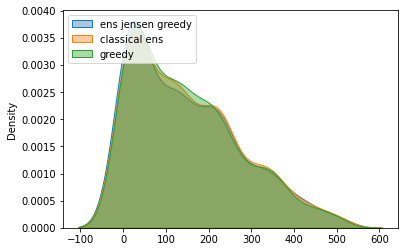

In [5]:
for p_ind, policy in enumerate(policies):
    print(f'{policy}: {utilities[p_ind, ..., -1].mean():.4f}')
    sns.kdeplot(utilities[p_ind, ..., -1].flatten(), alpha=0.4, shade=True, label=policy)
    
plt.legend(loc='upper left');

In [6]:
print(utilities.shape)
utilities

(3, 120, 5, 501)


array([[[[  1.,   1.,   1., ..., 215., 215., 216.],
         [  1.,   2.,   2., ..., 224., 224., 224.],
         [  1.,   1.,   1., ..., 201., 201., 201.],
         [  1.,   2.,   2., ..., 351., 351., 352.],
         [  1.,   1.,   1., ..., 224., 224., 224.]],

        [[  1.,   1.,   1., ..., 241., 241., 241.],
         [  1.,   1.,   2., ..., 268., 268., 268.],
         [  1.,   2.,   3., ..., 158., 158., 159.],
         [  1.,   1.,   2., ..., 151., 152., 153.],
         [  1.,   2.,   2., ..., 278., 278., 278.]],

        [[  1.,   1.,   1., ..., 147., 148., 149.],
         [  1.,   1.,   2., ..., 150., 150., 150.],
         [  1.,   2.,   2., ..., 183., 183., 183.],
         [  1.,   1.,   1., ..., 153., 153., 153.],
         [  1.,   1.,   1., ..., 119., 120., 121.]],

        ...,

        [[  1.,   1.,   2., ..., 211., 212., 212.],
         [  1.,   1.,   1., ..., 200., 200., 200.],
         [  1.,   2.,   3., ..., 221., 221., 221.],
         [  1.,   1.,   1., ..., 202., 203.,

In [7]:
squeezed_utilities =  utilities.reshape(
    len(policies), 
    num_exps * num_repeats_per_exp, 
    budget + init_size
)

print(squeezed_utilities.shape)
squeezed_utilities

(3, 600, 501)


array([[[  1.,   1.,   1., ..., 215., 215., 216.],
        [  1.,   2.,   2., ..., 224., 224., 224.],
        [  1.,   1.,   1., ..., 201., 201., 201.],
        ...,
        [  1.,   1.,   2., ..., 227., 227., 227.],
        [  1.,   2.,   3., ..., 209., 209., 210.],
        [  1.,   1.,   1., ..., 229., 229., 229.]],

       [[  1.,   1.,   1., ..., 140., 140., 140.],
        [  1.,   2.,   2., ..., 141., 141., 141.],
        [  1.,   1.,   1., ..., 199., 199., 199.],
        ...,
        [  1.,   1.,   2., ..., 228., 228., 228.],
        [  1.,   2.,   2., ..., 255., 255., 255.],
        [  1.,   1.,   1., ..., 242., 242., 242.]],

       [[  1.,   2.,   3., ..., 197., 198., 199.],
        [  1.,   1.,   2., ..., 196., 197., 198.],
        [  1.,   2.,   3., ..., 155., 155., 155.],
        ...,
        [  1.,   2.,   3., ..., 243., 243., 243.],
        [  1.,   2.,   3., ..., 211., 211., 211.],
        [  1.,   2.,   2., ..., 241., 242., 243.]]])

In [8]:
for p1 in range(len(policies) - 1):
    for p2 in range(p1 + 1, len(policies)):
        print(policies[p1], "vs.", policies[p2])
        print(
            ttest_rel(
                squeezed_utilities[p1, :, -1], 
                squeezed_utilities[p2, :, -1]
            ).pvalue
        )

ens jensen greedy vs. classical ens
0.0007616623958902183
ens jensen greedy vs. greedy
0.6063122788249887
classical ens vs. greedy
0.031993731636123963


136.9661606443947 157.35717268893862
5.097753011135978
140.62006105032992 160.88993894967007
5.067469474835036
137.8811073218008 157.74222601153252
4.965279672432928


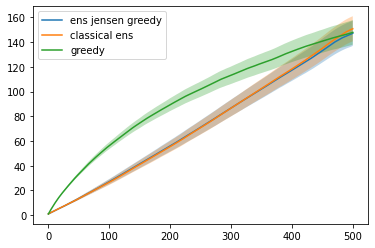

In [9]:
plt.figure()

for p_ind, policy in enumerate(policies):
    plt.plot(squeezed_utilities[p_ind].mean(axis=0), label=policy)
    lower, upper = DescrStatsW(squeezed_utilities[p_ind]).tconfint_mean()
    plt.fill_between(np.arange(init_size + budget), lower, upper, alpha=0.3)
    
    print(lower[-1], upper[-1])
    print((upper[-1] - lower[-1]) / 4)
    
plt.legend();